1. Make sure that b-splines are correct
    x. Check the code for obvious errors
    2. Write energy function that works with b-splines
    3. Check if the TPF and B-spline energies are the same
2. Write LinReg optimization function
3. Fit energy to an existing potential (e.g., Marinica)
4. Write Backfitting optimization function
5. Optimize stat. distance

In [1]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core

In [4]:
working = '../data/working'

In [620]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi)

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

len 50


(2.0, 5.86)

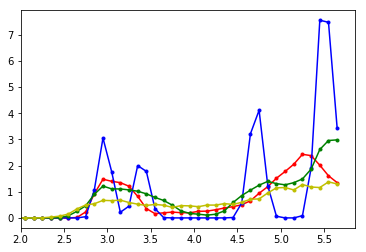

In [623]:
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.4, stats_bspline['fcc_npt_langevin_300K']['energy'][0][2][:-3], 'r.-')
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.4, stats_bspline['bcc_npt_langevin_300K']['energy'][0][2][:-3], 'b.-')
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.4, stats_bspline['bcc_npt_langevin_3700K']['energy'][0][2][:-3], 'g.-')
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.4, stats_bspline['liq_5000K']['energy'][0][2][:-3], 'y.-')
#plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-4-3]), stats_bspline['eos']['energy'][2][2][:-3], 'c.-')
plt.xlim(2.0)


In [624]:
target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

In [625]:
targets['eos']['box'] = targets['eos']['box'][5:6]
targets['eos']['xyz'] = targets['eos']['xyz'][5:6]
targets['eos']['temp'] = targets['eos']['temp'][5:6]
targets['eos']['beta'] = targets['eos']['beta'][5:6]
targets['eos']['energy'] = targets['eos']['energy'][5:6]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][5:6]

In [626]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][1:4]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][1:4]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][1:4]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][1:4]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][1:4]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][1:4]

In [627]:
len(targets['eos_bcc']['energy']), len(stats_bspline['eos_bcc']['energy'])

(3, 3)

In [628]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]

In [630]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [631]:
def Dbs(n, order, lo_bound=[], hi_bound=[]):
    """B-spline penalty matrix
    """
    
    pen = {0:[1.0],
           1:[1.0, -1.0],
           2:[1.0, -2.0, 1.0],
           3:[1.0, -3.0, 3.0, -1.0],
           4:[1.0, -4.0, 6.0, -4.0, 1.0]}   
    
    n_lo = len(lo_bound)
    n_hi = len(hi_bound)
    n_tot = n + n_lo + n_hi

    # Extended penalty matrix
    P = np.zeros((n_tot, n_tot), dtype=float)
    
    for i in range(n_tot-order):
        P[i, i:i+1+order] = pen[order]

    # Select inner part of the penalty matrix without constraints
    if n_hi > 0:
        D = np.copy(P[:,n_lo:-n_hi])
    else:
        D = np.copy(P[:,n_lo:])

    # Apply low and high constraints and sum them into 1D array
    C = np.zeros((n_tot), dtype=float)
    if n_lo > 0:
        C += P[:, :n_lo].dot(np.array(lo_bound))
    if n_hi > 0:
        C += P[:,-n_hi:].dot(np.array(hi_bound))
        
    print('c',C)
    

    return D, C

In [632]:
def penalty_matrix(partitions):
    """Constructs b-spline penalty matrix for a given Hamiltonian
    
    The resulting matrix is constructed for 1 or more b-splines
    and may exclude designated parameters. 

    Parameters
    ----------
    n : int, len(self.coef_)
        number of parameters defining number of matrix columns
    order : int or list of ints
        order of the stiffness penalty. If list of values is provided,
        multiple b-splines will be penalized by the given orders.
    exclude : list of ints
        List of indices of parameters to be excluded from penalties
    bounds : list of lists
        For each b-spline, have a list of virtual 
    lower_bound : 1D array-like
        defines virtual parameter values below the fitting region
    upper_bound : 1D array-like
        defines virtual parameter values above the fitting region
        
    Returns
    -------
    Dsqr : ndarray, shape (n_coeffs, n_coeffs)
        Square of the penalty matrix
    """
    
    penalty_degree = {0, 1, 2, 3, 4}
    
    # Penalty matrices and vectors for Hamiltonian partitions
    D_parts = []
    C_parts = []
    for n_part, p_degree, lo_bound, hi_bound in partitions:
        if p_degree == None: # no penalty
            dd = np.zeros((n_part, n_part), dtype=float)
            cc = np.zeros((n_part), dtype=float)
        elif p_degree in penalty_degree:
            dd, cc = Dbs(n_part, p_degree, lo_bound=lo_bound, hi_bound=hi_bound)
        else:
            raise ValueError("Unknown penalty: {}".format(ptype))

        D_parts.append(dd)
        C_parts.append(cc)
        print(cc.shape, dd.shape)

    # Penalty matrix as a block diagonal from submatrices
    C = np.concatenate(C_parts)
    D = block_diag(*D_parts)
    print('shapes', C.shape, D.shape)
    print('C', C)
    
    # Square of penalty matrix needed in loss and its derivatives
    CC = C.dot(C)
    CD = 2.0*C.dot(D)
    DD = D.T.dot(D)
    print('shapes2', CD.shape, DD.shape, CC.shape)

    return DD, CD, CC

In [715]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 0.0
targets['eos']['weight'] = 0.1
targets['eos_bcc']['weight'] = 0.1
targets['relax']['weight'] = 1.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 1.0),
 ('eos', 0.1),
 ('vac_npt_langevin_2000K', 1.0),
 ('inf', 0.0),
 ('relax', 1.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 1.0),
 ('eos_bcc', 0.1),
 ('liq_5000K', 1.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('liq_3700K', 1.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('bain', 0.0)]

In [676]:
mb_knots = list(np.linspace(3.75, 5.25, 16))
pair_knots = list(np.linspace(1.05, 5.25, 43))
#pair_knots = list(np.linspace(2.05, 5.25, 33))

print(mb_knots)
print(pair_knots)

# Select knots for optimization
# cycle over knots of selected models
stats_list = []
for knot in mb_knots:
    edens_knots = [knot]
    stats = downselect(stats_bspline, pair_knots, edens_knots)
    stats_list.append(stats)

[3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [677]:
low_knots = list(np.linspace(1.05, 1.25, 3))
coeffs_low = [u_core(r+0.2)/(6*0.1**3) for r in low_knots]
#coeffs_low = [0.0, 0.0, 0.0]
coeffs_low

[17113.755717924174, 11468.628163754847, 7820.796633088171]

In [678]:
partitions = []
partitions.append([2, None, None, None]) # Embedding function - no penalty
#partitions.append([len(pair_knots), 3, coeffs_low, []])
partitions.append([len(pair_knots), 3, [], []])

## Perform K-fold cross-validation based on leaving out different trajectories

* Get a list of trajectories
* For each cycle, leave one trajectory out
* Try different lambdas

In [598]:
trajs = targets.keys()
trajs.remove('eos')
trajs.remove('eos_bcc')
trajs.remove('eos_fcc')
trajs.remove('inf')
trajs.remove('bain')
trajs.remove('vacint')
len(trajs), trajs

(10,
 ['bcc_npt_langevin_3700K',
  'vac_npt_langevin_2000K',
  'relax',
  'screw_111_npt_langevin_2000K',
  'bcc_npt_langevin_300K',
  'liq_5000K',
  'fcc_npt_langevin_300K',
  'i110_npt_langevin_2000K',
  'liq_3700K',
  'i111_npt_langevin_2000K'])

In [109]:
def kfold_cv(stat, target, trajs, grid):
    """
    K-fold cross validation for a set of K trajectories.
    Leave-one-trajectory-out approach (rather than one sample out)
    """
    
    lamb_cv = []

    # cycle over hyperparameters
    for lamb in grid: 
        
        rss_list = []
        beta_list = []
        # select a trajectory to exclude from fitting
        for k in range(len(trajs)):
            
            # create target without k-th trajectory
            t = {key:val for key, val in target.items() if key != trajs[k]}
            
            # create statistics without k-th trajectory
            s = {key:val for key, val in stat.items() if key != trajs[k]}

            # build X and y for the K-1 set of trajectories
            X, y = make_matrices(t, s, weights=True)
            
            #print(X.shape, y.shape)
            b = np.linalg.inv(X.T.dot(X) + lamb*Dsqr).dot(X.T).dot(y)
            
            # least squares training error
            rss_train = (y - X.dot(b)).T.dot(y - X.dot(b))
            rss_train /= y.shape[0]
            
            # build X and y for the K-1 set of trajectories
            t = {key:val for key, val in target.items() if key == trajs[k]}
            s = {key:val for key, val in stat.items() if key == trajs[k]}
            X, y = make_matrices(t, s, weights=True)

            # least squares prediction error
            rss = (y - X.dot(b)).T.dot(y - X.dot(b))
            rss /= y.shape[0]
            rss_list.append(rss)
            #print(rss_train, rss, y.shape[0], trajs[k])

            beta_list.append(b)
            
        rss_list = np.array(rss_list)
        rss_ave = np.mean(rss_list)
        rss_min = np.min(rss_list)
        rss_max = np.max(rss_list)
        
        #print('average error:', round(lamb,3), round(rss_ave,2), round(rss_min,2), round(rss_max,2))

        lamb_cv.append((lamb, rss_ave, rss_min, rss_max))
        
    return np.array(lamb_cv)

In [34]:
grid = [0.0] + list(np.logspace(-3, 1, 80))

In [38]:
cv_scores = kfold_cv(stats, targets, trajs, grid)
lamb_best = sorted(cv_scores, key=lambda x: x[-1])[:10]
lamb_best

[array([ 2.77356261,  8.65243547,  0.78768547, 27.01521836]),
 array([ 2.46834047,  8.78302548,  0.79668093, 27.22214062]),
 array([ 3.11652694,  8.5193444 ,  0.75435658, 27.41022832]),
 array([ 3.50190046,  8.38484714,  0.70463052, 27.84451183]),
 array([ 3.93492726,  8.25035563,  0.65752954, 28.31973583]),
 array([ 4.42149991,  8.11762713,  0.61359319, 28.83729645]),
 array([ 2.19670709,  8.91030448,  0.80495149, 28.93824408]),
 array([ 4.96823959,  7.98878745,  0.57331253, 29.39826622]),
 array([ 5.58258627,  7.86634321,  0.53711136, 30.00334148]),
 array([ 1.95496614,  9.03371215,  0.81252515, 30.56759922])]

In [39]:
def best_params(stat, target, trajs, lamb):
    
    X, y = make_matrices(target, stat, weights=True)

    b = np.linalg.inv(X.T.dot(X) + lamb*Dsqr).dot(X.T).dot(y)
        
    #rss = (y - X.dot(b)).T.dot(y - X.dot(b))
    
    return b#, rss
    

## Minimizing statistical distance

1. Start from previously optimized parameters beta and lambda
2. Include additional b-splines basis functions 
3. Include additional constraints on beta at the short range
4. Set up Newton optimizer (as a function)

In [209]:
print(lamb_best[0][0])
b_old = best_params(stats, targets, trajs, lamb_best[0][0])
print(b_old)
plt.plot(b_old[2:])
plt.hlines(0.0, 0, 30)

2.773562614198415


array([-4.68020455e-01,  1.19572562e-04, -1.07303573e+01, -4.75704775e+01,
       -7.21260451e+01, -8.47411694e+01, -8.69632646e+01, -8.29147079e+01,
       -7.78537409e+01, -7.24653553e+01, -6.61306192e+01, -5.87192390e+01,
       -5.05491765e+01, -4.21690454e+01, -3.35418557e+01, -2.51721329e+01,
       -1.82340428e+01, -1.35690389e+01, -1.12700845e+01, -1.04314266e+01,
       -9.80240225e+00, -8.61393220e+00, -6.93472762e+00, -5.53827608e+00,
       -4.65907291e+00, -4.04983752e+00, -3.76141683e+00, -2.90408135e+00,
       -1.05092501e+00,  6.89720535e-01,  6.56155815e-01, -6.39500506e-01,
       -1.72143471e+00, -1.79801786e+00, -7.96160573e-01])

In [679]:
def make_sd_matrices(target, stats, keytrj=None, weights=False):
    """
    Creates input data for energy minimization with target as dependent variable and stats as independent.
    Assumes that all appropriate knots from stats have been selected, so it includes everything.
    """
    
    # matrix of independent variables (Embedding and B-spline coefficients)
    X = []
    # vector of dependent variable (configurational energies)
    y = []
    # bector of inverse temperatures
    beta = []
    
    keys = list(target.keys())
    keys.remove('eos')
    keys.append('eos')
    keys.remove('eos_bcc')
    keys.append('eos_bcc')
    keys.remove('relax')
    keys.append('relax')
    
    if keytrj is not None:
        keys = keytrj


    bounds = []

    for key in keys:
            
        # eliminate trajectories with 0 weight
        if weights:
            if target[key]['weight'] == 0.0:
                continue
        lo_bound = len(y)
        for i, (config, energy, bb) in enumerate(zip(stats[key]['energy'], target[key]['energy'], target[key]['beta'])):
            # add energy
            y.append(energy)
            beta.append(bb)
            
            # create an array of independent variables
            x_vars = [config[0][0], config[1][0]] # embedding
            #print('x_vars', x_vars, key, i, stats[key]['energy'][0][0], stats[key]['energy'][1][0])
            #print('x_vars', x_vars, stats[key]['energy'][0][0], stats[key]['energy'][1][0])

            #print('config[2]', config[2])
            x_vars += list(config[2])                   # pair interaction b-spline stats
            X.append(x_vars)
            
#             if key == 'relax':
#                 for i in range(100):
#                     y.append(energy)
#                     beta.append(bb)
#                     X.append(x_vars)
        bounds.append([lo_bound, len(y)])

    return np.array(X), np.array(y), np.array(beta), bounds


1. Add penalty to N-R
2. Take care of short distance repulsion
3. Modify inspect notebook to see the results
4. Convert to Yuri's format (inversion of the transformation matrix to TPF basis?)

In [680]:


partitions = []
partitions.append([2, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, [], []])

In [681]:
Dp, Cp, c2 = penalty_matrix(partitions)
c2, Cp, Dp[:]

((2,), (2, 2))
('c', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]))
((43,), (43, 43))
('shapes', (45,), (45, 45))
('C', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
('shapes2', (45,), (45, 45), ())


(0.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   1., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,  19., -12.,   3.],
        [  0.,   0.,   0., ..., -12.,  10.,  -3.],
        [  0.,   0.,   0., ...,   3.,  -3.,   1.]]))

In [682]:
Dsqr = Dp

In [724]:
def newton_raphson_weighted(X, y, beta, b_init, lamb=0.0, weights=None, tol=1e-4, itmax=10000):
    
    b_old = copy.copy(b_init)
    loss_old = 0.0
    
    if weights is not None:
        assert len(weights) == len(y), "Wrong weight list"
        ww = np.diag(weights)
    else:
        ww = np.identity(len(y))
    
    itcount = 0
    while True:

        # Jacobian (gradient of the loss function)
        
        P = np.exp(-0.5*beta*(X.dot(b_old) - y))
        P2 = P**2

        #J = X.T.dot(P-P2) + lamb*Dsqr.dot(b_old)
        
        # Inverse Hessian
        W = np.diag(0.5*P - P2) # weight matrix
        W = ww.dot(W)
        H = X.T.dot(W).dot(X) - lamb*Dsqr
        Hi = np.linalg.inv(H)

        # N-R update
        #b_new = b_old - Hi.dot(J)#dot(X.T).dot(P - P2)
        #b_new = Hi.dot(X.T).dot(W).dot(X.dot(b_old) + Wi.dot(P - P2))
        
        b_new = Hi.dot(X.T).dot(W.dot(X).dot(b_old) + ww.dot(P - P2))

        
        # Loss from the previous step
        loss = np.arccos(1. - (1 - P).T.dot(ww).dot(1 - P)/(2.0*np.sum(ww)))**2
        loss_full = loss + 0.5*lamb*b_old.T.dot(Dsqr).dot(b_old)
        
        df = abs((loss-loss_old)/loss)
        
        if itcount % 100 == 0:
            print(itcount, loss, loss_full, np.sum(abs(b_new - b_old)), df, beta[0], 1/beta[0])

        print(np.sum(abs(b_new - b_old)), abs(df))
        if (np.sum(abs(b_new - b_old)) < tol) or itcount > itmax or abs(df) < 1e-7:
            break
            
        itcount += 1
        b_old = b_new
        loss_old = loss
    
    return b_new, loss

(1.0, 5.65)

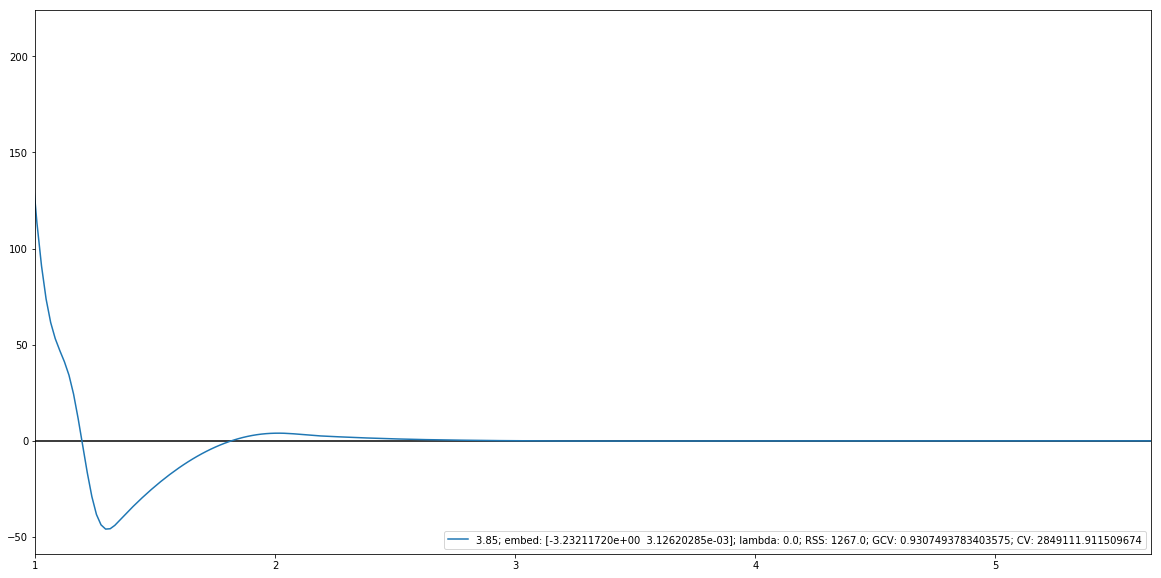

In [725]:
plt.figure(figsize=(20,10))
betas = []
for i, stat in enumerate(stats_list[1:2]):
#     if i != 1:
#         continue
    #for lamb in list(np.logspace(-3, np.log10(2.774), 4)):
    for lamb in [1e-8]:
        X, y, bbb, bounds = make_sd_matrices(targets, stat, weights=True)
        
        #print(X[0])
        
        weight = np.ones(len(y), dtype=float)
        weight[-6:] = 50.0
        weight[-9:-6] = 0.1
        ww = np.diag(weight)
        
        b = np.linalg.inv(X.T.dot(ww).dot(X) + 0.5*lamb*Dp).dot(X.T.dot(ww).dot(y) - 0.5*lamb*Cp)
        
        rss = (y - X.dot(b)).T.dot(y - X.dot(b))

        label_str = str(round(stat['hyperparams']['edens'][0], 2))
        label_str += '; embed: ' + str(b[:2])
        label_str += '; lambda: ' + str(round(lamb, 4))
        label_str += '; RSS: ' + str(round(rss, 0))
        
        hat = X.dot(np.linalg.inv(X.T.dot(X) + lamb*Dp)).dot(X.T)

        hat_trace = np.trace(hat)
        gcv = (y - X.dot(b)).T.dot(y - X.dot(b))/(X.shape[0] - hat_trace)
        label_str += '; GCV: ' + str(gcv)#str(round(gcv, 0))
        
        vec = (y - X.dot(b))/(1. - np.diag(hat))
        cv = vec.T.dot(vec)
        
        label_str += '; CV: ' + str(cv)#str(round(gcv, 0))

    #plt.plot(np.array(pair_knots)+0.2, b[2:], label=label_str)
    
        rr = np.linspace(0.95, 5.7, 250)
#         coeffs = [17113.755717924174, 11468.628163754847, 7820.796633088171] + list(b[2:])
#         knots = [1.05, 1.15, 1.25] + pair_knots + [5.35, 5.45, 5.55, 5.65]
#        coeffs = [2000, 500, 100., 10.] + list(b[2:])
#        coeffs = [0.0, 0.0, 0.0, 0.0] + list(b[2:])

        coeffs = coeffs_low[-1:] + list(b[2:])
#        coeffs = [0.0, 0, 0] + list(b[2:])

        knots = [1.05, 1.15, 1.25][-1:] + pair_knots +[5.35, 5.45, 5.55, 5.65]

#        knots = [1.65, 1.75, 1.85, 1.95] + pair_knots +[5.35, 5.45, 5.55, 5.65]
#         coeffs = list(b[2:])
#         knots = pair_knots +[5.35, 5.45, 5.55, 5.65]
    #bs = [180*make_bspline(b[2:], pair_knots+[5.35, 5.45, 5.55, 5.65], r) for r in rr]
        bs = [make_bspline(coeffs, knots, r) for r in rr]

        plt.plot(rr, bs, label=label_str)
    
        betas.append(b)

plt.hlines(0,1,6)
plt.legend(loc='lower right')
#plt.ylim(-100,2000)
#plt.ylim(-0.6,1)
plt.xlim(1.0,5.65)

In [726]:
b_init = betas[0]
b_init = b_weight10

In [727]:
for i, stat in enumerate(stats_list[1:2]):

    X, y, beta, bounds = make_sd_matrices(targets, stat, weights=True)
    weight = np.ones(len(y), dtype=float)
    weight[-6:] = 40.0
    #weight[-9:-6] = 0.2
    print(X.shape, y.shape, beta.shape, b_init.shape, weight.shape)

    #b_final, loss_final = newton_raphson_penalized(X, y, beta, b_init, lamb=1e-4, weights=None, itmax=1e5)
    b_final, loss_final = newton_raphson_weighted(X, y, beta, b_init, lamb=1e-3, weights=weight, itmax=1e5)

((1399, 45), (1399,), (1399,), (45,), (1399,))
(0, 3.6502190470363053e-07, 0.19730210942360946, 0.07200679812523998, 1.0, 0.00030135095633725996, 3318.39)
(0.07200679812523998, 1.0)
(0.16121722514663722, 8.753500053143404e-07)
(0.1058906214979348, 7.968781050410002e-07)
(0.2937475666398441, 7.445634158052448e-07)
(0.16356131899904486, 7.141477329783865e-07)
(0.19598764876389616, 6.624415388625474e-07)
(0.18382515084801637, 6.210765759213424e-07)
(0.21113023898932487, 5.371305794194541e-07)
(0.06422990102871601, 5.054986250169639e-07)
(0.061350949328587166, 4.446682681852973e-07)
(0.20852811855402903, 4.3189375346223794e-07)
(0.13180543196035346, 3.5524769383014206e-07)
(0.23908054675271437, 2.9076771939341804e-07)
(0.14264900220192714, 2.6643562213127083e-07)
(0.1361387598670556, 2.1108023109008195e-07)
(0.32940942019586084, 1.7154067703328017e-07)
(0.05890998871492242, 1.0401933588393217e-07)
(0.10753923194971725, 3.5281410986597436e-08)


In [728]:
b_weight10 = b_final
b_weight9

array([-2.92971306e+00,  3.78470896e-03,  2.77860806e+03,  2.40289469e+03,
        2.05613508e+03,  1.73832906e+03,  1.44947609e+03,  1.18957547e+03,
        9.58626472e+02,  7.56628553e+02,  5.83581502e+02,  4.39485628e+02,
        3.24143190e+02,  2.35581533e+02,  1.68759649e+02,  1.17094392e+02,
        7.72033786e+01,  4.87052442e+01,  2.28010950e+01,  6.43836336e+00,
       -7.89759130e+00, -1.93104721e+01, -2.48819890e+01, -2.36033162e+01,
       -2.06585740e+01, -1.90681535e+01, -1.75040614e+01, -1.54819550e+01,
       -1.37607708e+01, -1.24011764e+01, -1.12159749e+01, -1.00311174e+01,
       -1.07742500e+01, -1.28068372e+01, -9.04323722e+00, -5.91652106e+00,
       -8.20338937e+00, -4.36299049e+00, -9.06376851e-02,  6.19338951e-01,
       -3.71148046e+00,  7.38079747e-01, -2.14168791e+00, -3.11684289e-01,
       -3.17224344e-01])

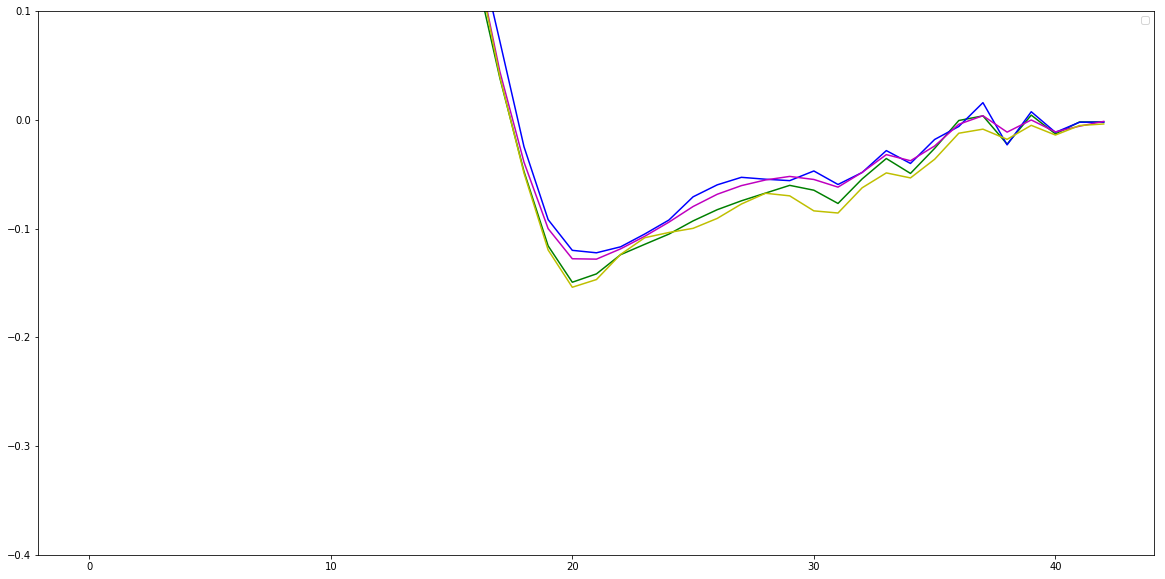

In [729]:
plt.figure(figsize=(20,10))
plt.plot(np.array(b_weight9[2:])*(6*0.1**3) , 'g')
plt.plot(np.array(b_weight8[2:])*(6*0.1**3) , 'b')
plt.plot(np.array(b_weight7[2:])*(6*0.1**3) , 'm')
plt.plot(np.array(b_weight10[2:])*(6*0.1**3) , 'y')
plt.ylim(-0.4,0.1)
plt.legend()

[-1139.01, 0.0, -1136.29, -1136.764, -1190.466, -1127.307]
[-1138.976, 0.0, -1136.365, -1136.702, -1190.319, -1127.407]
[-1139.07, 0.0, -1136.368, -1136.707, -1190.366, -1127.295]
[-1138.809, 0.0, -1136.474, -1136.613, -1190.994, -1127.045]
[-1139.2, -0.0, -1136.401, -1136.751, -1190.261, -1127.175]


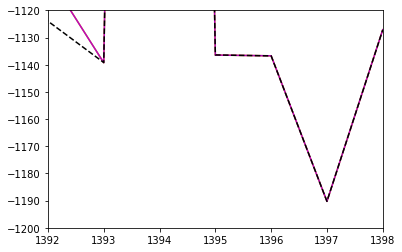

In [731]:
plt.plot(X.dot(b_weight5), 'y')
plt.plot(X.dot(b_weight4), 'm')
plt.plot(y, 'k--')
plt.xlim(len(X)-7,len(X)-1)
plt.ylim(-1200,-1120)

#print(list(y[382:389]), list(X.dot(b_0)[382:389]))
print([round(z, 3) for z in X.dot(b_weight9)[-6:]])
print([round(z, 3) for z in X.dot(b_weight8)[-6:]])
print([round(z, 3) for z in X.dot(b_weight7)[-6:]])
print([round(z, 3) for z in X.dot(b_weight10)[-6:]])
print([round(z, 3) for z in y[-6:]])

In [732]:
# stats_file = 'stats_bs_samples' # 'stats_samples'
# with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
#     stats_tpf = pickle.load(fi)

# stats_bspline = tpf_to_bsplines(stats_tpf)

# target_file = 'target_bs_samples'
# with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
#     targets = pickle.load(fi)

In [733]:
for key in targets.keys():
    targets[key]['weight'] = 1.0

In [734]:
tkeys = ['bcc_npt_langevin_300K',
'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [735]:
for i, stat in enumerate(stats_list[1:2]):
    Xall, yall, beta, bounds = make_sd_matrices(targets, stat, keytrj=tkeys, weights=False)

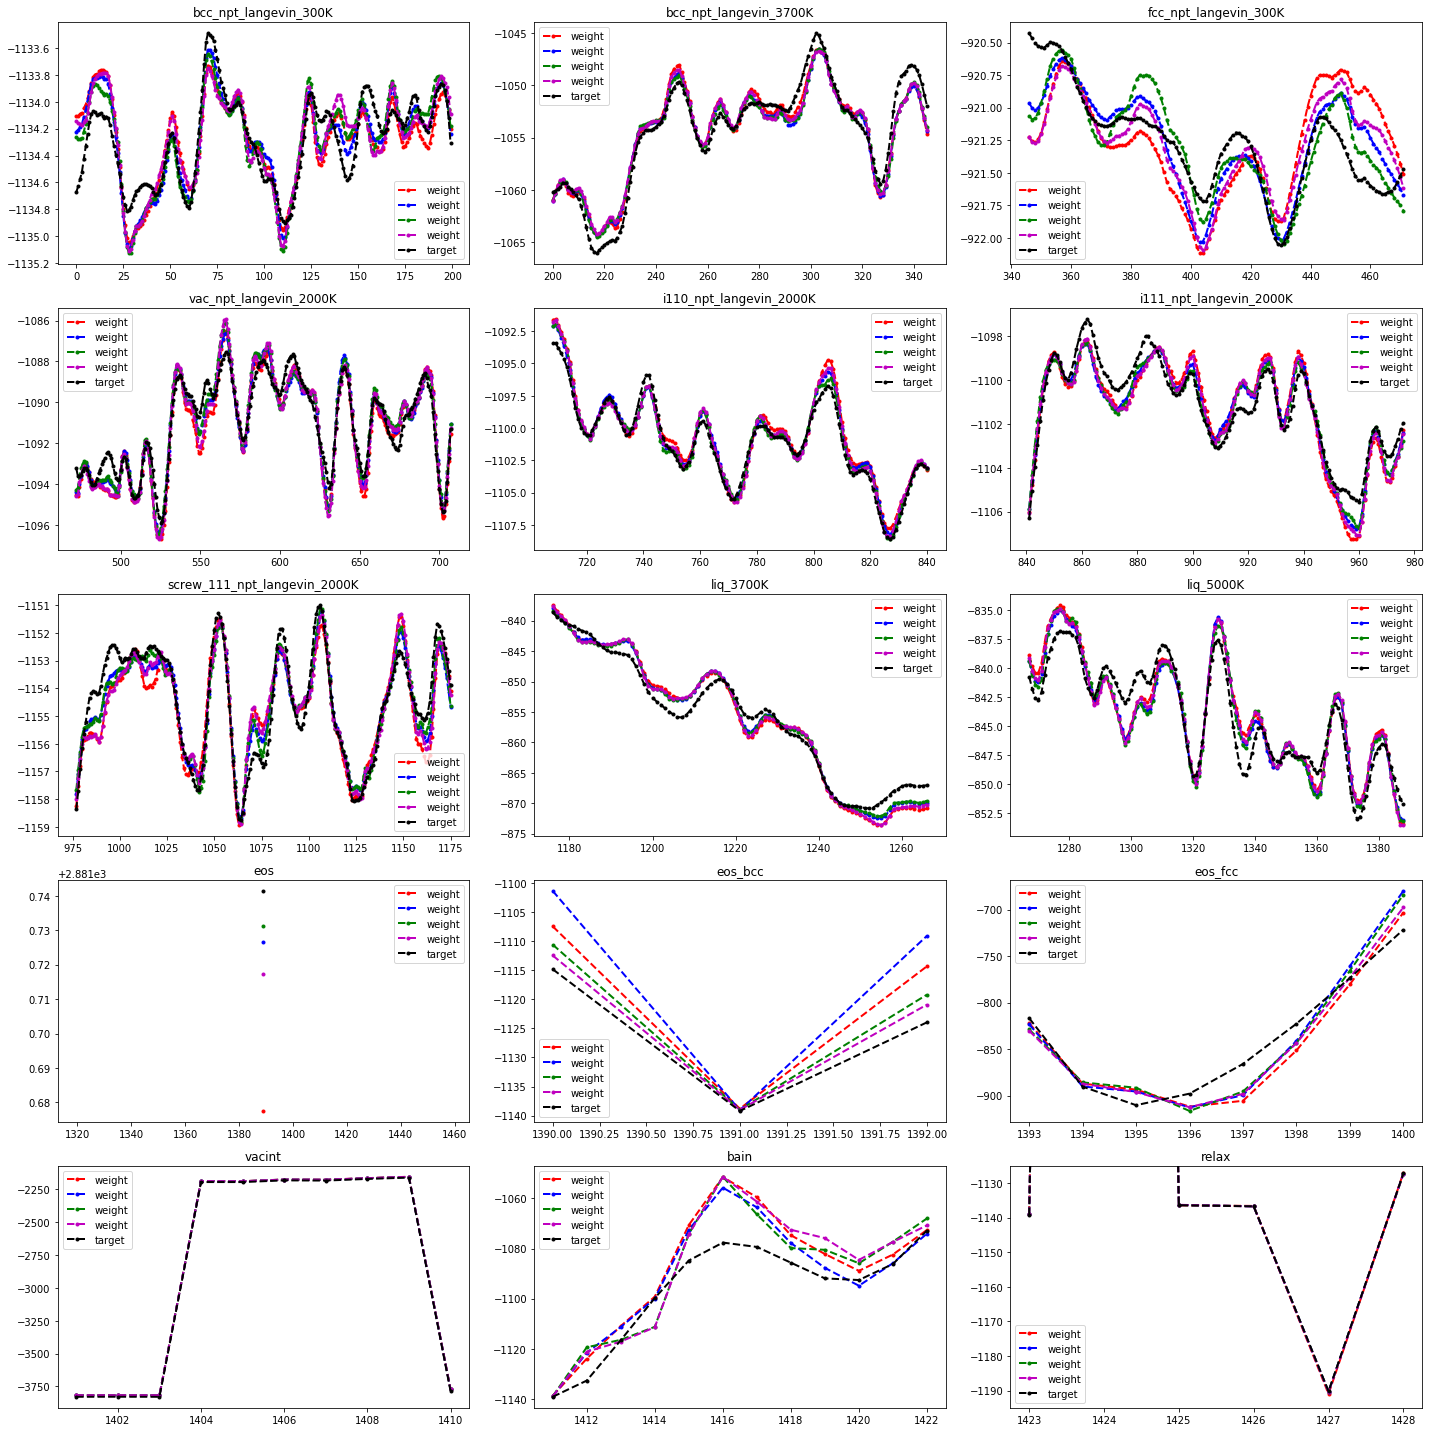

In [739]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(bounds[k][0], bounds[k][1]))

    axes[i,j].plot(rr, Xall.dot(b_weight10)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
    axes[i,j].plot(rr, Xall.dot(b_weight7)[bounds[k][0]:bounds[k][1]], 'b.--', lw=2, label='weight')
    axes[i,j].plot(rr, Xall.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
    axes[i,j].plot(rr, Xall.dot(b_weight9)[bounds[k][0]:bounds[k][1]], 'm.--', lw=2, label='weight')
    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')

    axes[i,j].plot(rr, yall[bounds[k][0]:bounds[k][1]], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
#     if trj == 'eos':
#         axes[i,j].set_ylim(-1195, 0)
#         axes[i,j].set_xlim(1390,1392)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [ ]:
b_weight8 - best